\begin{aligned}
-\Delta u & = f && \text {En una resistencia eléctrica},
\\
&\alpha u − \beta = 0 && \text{Con condición en la frontera tipo Robin}\\
& max = z = Temp_{max}\cdot \sqrt{area} && \text{Función Objetivo}
\end{aligned}

- `import numpy as np`: Importa la librería NumPy con el alias np.
- `from ngsolve import *`: Importa todo desde el módulo ngsolve.
- `from ngsolve.webgui import Draw`: Importa la función Draw del módulo ngsolve.webgui.
- `from netgen.geom2d import CSG2d, Circle, Rectangle`: Importa las clases CSG2d, Circle y Rectangle del módulo netgen.geom2d.
- `import matplotlib.pyplot as plt`: Importa la librería matplotlib.pyplot con el alias lt.


In [6]:
import numpy as np
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.geom2d import CSG2d, Circle, Rectangle
import matplotlib.pyplot as plt

- `def areamax_tempmax(espesor, radio_externo, longitud_segmentos_rectos,graficar):`: Define una función para calcular el área y la temperatura máxima de una geometría.

  - `geo = CSG2d()`: Crea una geometría en 2D usando CSG2d.

  - `circle1 = Circle(...)`, `circle2 = Circle(...)`, `rect1 = Rectangle(...)`, `rect2 = Rectangle(...)`: Define círculos y rectángulos para la geometría.

  - `domain3 = (circle1 + rect1) - (circle2 + rect2)`: Combina los círculos y rectángulos para formar la geometría final.

  - `mesh = geo.GenerateMesh(maxh=espesor/4)`: Genera una malla para la geometría.

  - `if graficar: Draw(mesh)`: Si `graficar` es verdadero, muestra la malla.

  - `fes = H1(mesh, order=1, dirichlet="bc_rect1|bc_circle1")`: Define un espacio de funciones H1 con condiciones de contorno Dirichlet.

  - `area = Integrate(cf, mesh, VOL, region_wise=True)`: Calcula el área de la geometría.

  - `if graficar: print("Área de la geometría:", area)`: Si `graficar` es verdadero, imprime el área.

  - `a = BilinearForm(fes)`, `f = LinearForm(fes)`: Define formas bilineales y lineales para resolver el problema de transferencia de calor.

  - `gfu.Set(CF(g), BND)`: Impone una condición de contorno de Dirichlet en la frontera.

  - `a += alpha * u * v * ds(robin_boundary)`, `f += -beta * v * ds(robin_boundary)`: Agrega términos de la condición de Robin a la forma bilineal y lineal.

  - `solvers.BVP(bf=a, lf=f, gf=gfu, pre=c)`: Resuelve el problema de transferencia de calor.

  - `if graficar: Draw(gfu)`: Si `graficar` es verdadero, muestra la solución.

  - `max_temp = np.max(gfu.vec.data)`: Calcula la temperatura máxima.

  - `print(f"Máximo valor de la temperatura: {max_temp}")`: Imprime el máximo valor de la temperatura.

  - `return area,max_temp`: Retorna el área y la temperatura máxima.


In [7]:
# Función para calcular el área de la resistencia
def areamax_tempmax(espesor, radio_externo, longitud_segmentos_rectos,graficar):
    # Crear geometría
    geo = CSG2d()
    circle1 = Circle(center=(longitud_segmentos_rectos + np.sqrt(radio_externo**2-4), 2), radius=radio_externo, mat="mat1", bc="bc_circle1")
    circle2 = Circle(center=(longitud_segmentos_rectos + np.sqrt(radio_externo**2-4), 2), radius=radio_externo - espesor, mat="mat2", bc="bc_circle2")
    rect1 = Rectangle(pmin=(0, 0), pmax=(longitud_segmentos_rectos, 4), mat="mat1", bc="bc_rect1")
    rect2 = Rectangle(pmin=(-0.5, espesor), pmax=(longitud_segmentos_rectos+2*espesor, 4-espesor), mat="mat2", bc="bc_rect2")
    domain3 = (circle1 + rect1) - (circle2 + rect2)
    geo.Add(domain3)
    # Generar malla
    mesh = geo.GenerateMesh(maxh=espesor/4)
    mesh = Mesh(mesh)
    mesh.Curve(1)
    if graficar: 
        Draw(mesh)
    
    # Calcular el área
    fes = H1(mesh, order=1, dirichlet="bc_rect1|bc_circle1")
    u = fes.TrialFunction()  # symbolic object
    v = fes.TestFunction()   # symbolic object
    gfu = GridFunction(fes)  # solution 
    g = 283.15 #imposición de condición tipo dirichlet
    cf = mesh.RegionCF(VOL, dict(mat1=1))
    area = Integrate(cf, mesh, VOL, region_wise=True)
    if graficar:
        print("Área de la geometría:", area)
    temp_max=g
    # Definir función de prueba y de prueba
    u = fes.TrialFunction()
    v = fes.TestFunction()

    # Definir coeficiente de conductividad
    cond = 320*100 #conductividad térmica 100*kg*cm/(K*s^3)

    # Definir forma bilineal
    a = BilinearForm(fes)
    a += grad(u)*grad(v)*cond*dx

    # Definir forma lineal
    P=1.0E7
    Q=P/area[0] # pendiente por calcular generación de calor x unidad de volumen 
    f = LinearForm(fes)
    f += Q*v*dx
    # Imponer condiciones de contorno de Dirichlet
    gfu.Set(CF(g), BND)
    #gfu.Set(CF(0), definedon=mesh.Boundaries("bc_rect1"))
# Resolver sistema lineal
    a.Assemble()
    f.Assemble()
    print("Assemble")
    print("GridFunction")
    # Transferencia de calor en la frontera: q = H * (u - T_amb) = H * u - H*T_amb
    # entonces, visto como condición Robin: q = alpha*u + beta ==> alpha = H, beta = -H*T_amb
    H = 250  # coeficiente de convección H W/(m^2 * K) = (kg m^2/s^3) / (m^2 K) = (kg cm^2/s^3) / (cm^2 K)
    T_amb = 283.15  # temperatura ambiente
    alpha = H
    beta = -H * T_amb
    robin_boundary = 'bc_rect1|bc_circle1|bc_circle2'
    a += alpha * u * v * ds(robin_boundary)
    f += -beta * v * ds(robin_boundary)
    c = Preconditioner(a,"direct") #<- sparse direct solver
    c.Update()
    solvers.BVP(bf=a, lf=f, gf=gfu, pre=c);
    if graficar:
        Draw(gfu)
    max_temp = np.max(gfu.vec.data)
    print(f"Máximo valor de la temperatura: {max_temp}")
    return area,max_temp

- `espesor = 1.9`, `radio_externo = 8`, `longitud_segmentos_rectos = 5`: Definen los parámetros para el cálculo del área de la resistencia y el algoritmo genético.

- `population_size = 20`, `num_iterations = 10`, `mutation_rate = 0.01`, `crossover_rate = 0.4`, `elitism = False`: Establecen los parámetros del algoritmo genético, como el tamaño de la población, el número de iteraciones, la tasa de mutaciones, la tasa de cruce y si se aplica elitismo.

- `espesor_range = (0.2, 1.8)`, `radio_externo_range = (5.0, 12)`: Definen el rango de valores para las variables espesor y radio_externo.

- `population = np.random.rand(population_size,2)`: Genera una población inicial aleatoria dentro de los rangos especificados.

- `def objective_function(x, longitud_segmentos_rectos, graficar)`: Define la función objetivo que utiliza `areamax_tempmax` para calcular el área y la temperatura máxima para una geometría dada por `x`.

- `fitness = np.array([objective_function(x, longitud_segmentos_rectos, graficar=True) for x in population])`: Evalúa la población inicial utilizando la función objetivo.

- `best_idx = np.argmax(fitness)`: Encuentra el índice del mejor individuo en la población.

- `best_solution = population[best_idx]`, `best_fitness = fitness[best_idx]`: Extrae la mejor solución y su rendimiento.

- `print(f"Mejor solución (espesor, radio_externo): {best_solution}")`, `print(f"Mejor rendimiento: {best_fitness}")`: Muestra la mejor solución y su rendimiento.

- `area, temp_max = areamax_tempmax(espesor=best_solution[0], radio_externo=best_solution[1], longitud_segmentos_rectos=longitud_segmentos_rectos, graficar=True)`: Calcula el área y la temperatura máxima para la mejor solución.

- `print(f"Área: {area}, Temperatura Máxima: {temp_max}")`: Muestra el área y la temperatura máxima para la mejor solución.


In [8]:
# Parámetros para el área_resistencia y el algoritmo genético
espesor = 1.9
radio_externo = 8
longitud_segmentos_rectos = 5
# Parámetros del algoritmo genético
population_size = 20 # tamaño de la población
num_iterations = 10 # número de iteraciones
mutation_rate = 0.01 # tasa de mutaciones
crossover_rate = 0.4 # tasa de cruce
elitism = False

# Rango de valores para las variables espesor y radio_externo
espesor_range = (0.2, 1.8)
radio_externo_range = (5.0, 12)
population = np.random.rand(population_size,2)
population[:,0]=population[:,0]*(espesor_range[1]-espesor_range[0])+espesor_range[0]
population[:,1]=population[:,1]*(radio_externo_range[1]-radio_externo_range[0])+radio_externo_range[0]
# Función objetivo
def objective_function(x, longitud_segmentos_rectos, graficar):
    area,temp_max = areamax_tempmax(espesor=x[0], radio_externo=x[1], longitud_segmentos_rectos=longitud_segmentos_rectos,graficar=graficar)
    T_amb=283.15
    return temp_max*np.sqrt(area)

# Evaluación de la población inicial
fitness = np.array([objective_function(x, longitud_segmentos_rectos, graficar=True) for x in population])

# Encontrar el índice del mejor individuo
best_idx = np.argmax(fitness)

# Extraer la mejor solución y su rendimiento
best_solution = population[best_idx]
best_fitness = fitness[best_idx]

# Mostrar los resultados
print(f"Mejor solución (espesor, radio_externo): {best_solution}")
print(f"Mejor rendimiento: {best_fitness}")

# Calcular el área y la temperatura máxima para la mejor solución
area, temp_max = areamax_tempmax(espesor=best_solution[0], radio_externo=best_solution[1], longitud_segmentos_rectos=longitud_segmentos_rectos, graficar=True)

# Mostrar las especificaciones completas
print(f"Área: {area}, Temperatura Máxima: {temp_max}")

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  60.0874

Assemble
GridFunction
CG iteration 1, residual = 724416.6741710785     
CG iteration 2, residual = 4.666464023881968e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Máximo valor de la temperatura: 288.3225344501688


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  69.9594

Assemble
GridFunction
CG iteration 1, residual = 680865.0433802312     
CG iteration 2, residual = 4.275937355196691e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Máximo valor de la temperatura: 289.0433037375586


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  102.537

Assemble
GridFunction
CG iteration 1, residual = 771424.976726213     
CG iteration 2, residual = 4.785351271774842e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Máximo valor de la temperatura: 287.906443054401


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  87.4098

Assemble
GridFunction
CG iteration 1, residual = 825701.4668591486     
CG iteration 2, residual = 5.090157870013807e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Máximo valor de la temperatura: 287.23224001797985


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:   21.574

Assemble
GridFunction
CG iteration 1, residual = 1510696.6043893374     
CG iteration 2, residual = 9.855393560193152e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Máximo valor de la temperatura: 284.3270328886068


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  109.229

Assemble
GridFunction
CG iteration 1, residual = 650856.0369356775     
CG iteration 2, residual = 4.29562913223732e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Máximo valor de la temperatura: 289.8021975595037


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  67.7488

Assemble
GridFunction
CG iteration 1, residual = 675467.3920911006     
CG iteration 2, residual = 4.0901954286709095e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Máximo valor de la temperatura: 289.12701127459417


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  77.8159

Assemble
GridFunction
CG iteration 1, residual = 801965.0633234142     
CG iteration 2, residual = 5.426466042791513e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Máximo valor de la temperatura: 287.4519759971288


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  84.3565

Assemble
GridFunction
CG iteration 1, residual = 846774.952259669     
CG iteration 2, residual = 5.07697224036021e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Máximo valor de la temperatura: 287.0333116923235


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  20.3532

Assemble
GridFunction
CG iteration 1, residual = 1270695.107315292     
CG iteration 2, residual = 7.939030153712001e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Máximo valor de la temperatura: 284.7454839173347


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  75.3221

Assemble
GridFunction
CG iteration 1, residual = 793793.3108055197     
CG iteration 2, residual = 5.134535199009977e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Máximo valor de la temperatura: 287.54930246702713


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  73.1905

Assemble
GridFunction
CG iteration 1, residual = 603074.6015981016     
CG iteration 2, residual = 3.516727001669606e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Máximo valor de la temperatura: 290.77928253380446


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  41.3333

Assemble
GridFunction
CG iteration 1, residual = 857946.5320636271     
CG iteration 2, residual = 5.079953577903387e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Máximo valor de la temperatura: 286.7371180285652


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  33.3529

Assemble
GridFunction
CG iteration 1, residual = 962304.7575072274     
CG iteration 2, residual = 6.325132674946276e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Máximo valor de la temperatura: 285.9711000922844


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  100.087

Assemble
GridFunction
CG iteration 1, residual = 737772.015069661     
CG iteration 2, residual = 5.224642682669586e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Máximo valor de la temperatura: 288.28773258778193


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  135.312

Assemble
GridFunction
CG iteration 1, residual = 689922.929874761     
CG iteration 2, residual = 4.446818368968907e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Máximo valor de la temperatura: 289.1635005032595


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  67.8583

Assemble
GridFunction
CG iteration 1, residual = 771076.6535089328     
CG iteration 2, residual = 4.841623905980401e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Máximo valor de la temperatura: 287.7897936326625


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  30.8994

Assemble
GridFunction
CG iteration 1, residual = 937725.9256025965     
CG iteration 2, residual = 6.139453566484871e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Máximo valor de la temperatura: 286.08387339001905


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  24.7861

Assemble
GridFunction
CG iteration 1, residual = 972843.0746430004     
CG iteration 2, residual = 6.024794969687944e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Máximo valor de la temperatura: 285.84397788088717


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  59.8651

Assemble
GridFunction
CG iteration 1, residual = 565291.623383067     
CG iteration 2, residual = 4.173374816135507e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Máximo valor de la temperatura: 291.72759715610925
Mejor solución (espesor, radio_externo): [ 1.79112933 11.42869366]
Mejor rendimiento: [3363.65184015]


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  135.312

Assemble
GridFunction
CG iteration 1, residual = 689922.929874761     
CG iteration 2, residual = 4.446818368968907e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Máximo valor de la temperatura: 289.1635005032595
Área:  135.312
, Temperatura Máxima: 289.1635005032595


Assemble
GridFunction
CG iteration 1, residual = 650856.0369356775     
CG iteration 2, residual = 4.29562913223732e-10     
Máximo valor de la temperatura: 289.8021975595037
Assemble
GridFunction
CG iteration 1, residual = 793793.3108055197     
CG iteration 2, residual = 5.134535199009977e-10     
Máximo valor de la temperatura: 287.54930246702713
Assemble
GridFunction
CG iteration 1, residual = 737772.015069661     
CG iteration 2, residual = 5.224642682669586e-10     
Máximo valor de la temperatura: 288.28773258778193
Assemble
GridFunction
CG iteration 1, residual = 937725.9256025965     
CG iteration 2, residual = 6.139453566484871e-10     
Máximo valor de la temperatura: 286.08387339001905
Assemble
GridFunction
CG iteration 1, residual = 673241.0822555812     
CG iteration 2, residual = 4.932085854324833e-10     
Máximo valor de la temperatura: 289.3553122551711
Assemble
GridFunction
CG iteration 1, residual = 646954.124668836     
CG iteration 2, residual = 3.896551443110219e-10

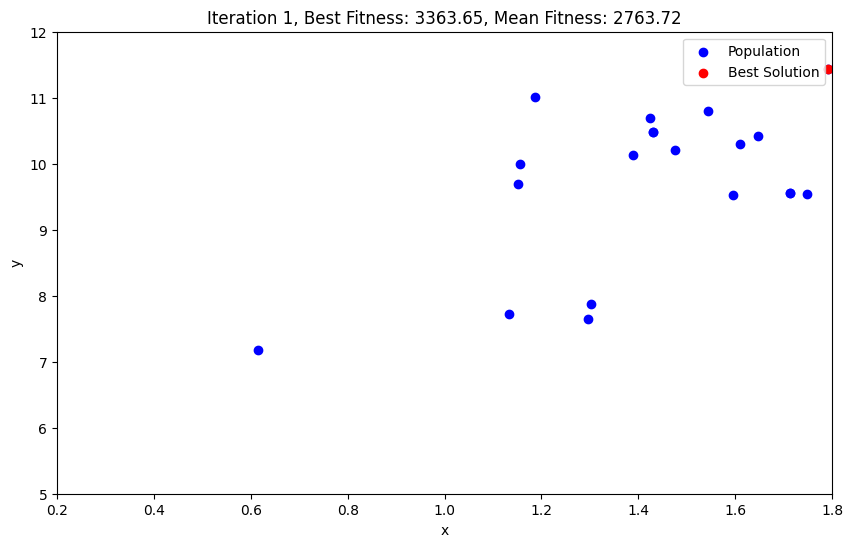

Assemble
GridFunction
CG iteration 1, residual = 650856.0369356775     
CG iteration 2, residual = 4.29562913223732e-10     
Máximo valor de la temperatura: 289.8021975595037
Assemble
GridFunction
CG iteration 1, residual = 825701.4668591486     
CG iteration 2, residual = 5.090157870013807e-10     
Máximo valor de la temperatura: 287.23224001797985
Assemble
GridFunction
CG iteration 1, residual = 641422.0733043401     
CG iteration 2, residual = 4.267414341753212e-10     
Máximo valor de la temperatura: 290.1162236398143
Assemble
GridFunction
CG iteration 1, residual = 636766.2915111745     
CG iteration 2, residual = 4.473956411961151e-10     
Máximo valor de la temperatura: 290.18248287278203
Assemble
GridFunction
CG iteration 1, residual = 673241.0822555812     
CG iteration 2, residual = 4.932085854324833e-10     
Máximo valor de la temperatura: 289.3553122551711
Assemble
GridFunction
CG iteration 1, residual = 673241.0822555812     
CG iteration 2, residual = 4.932085854324833e-1

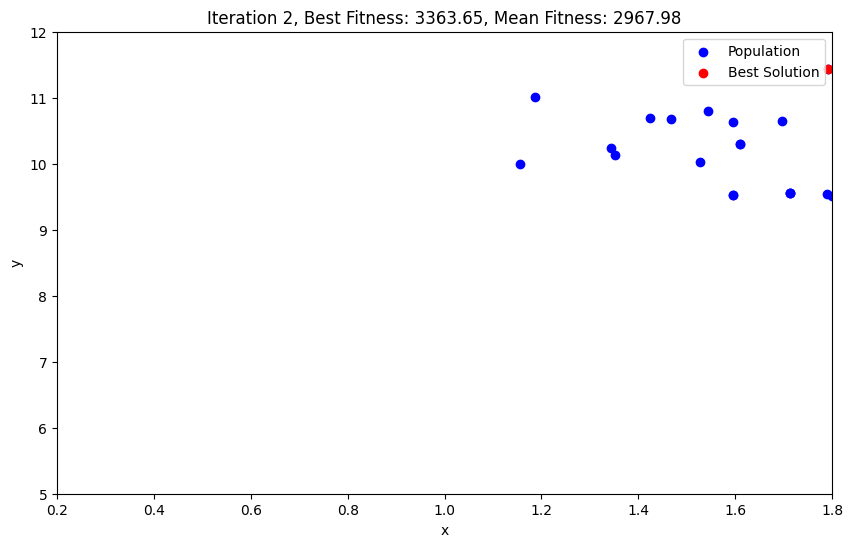

Assemble
GridFunction
CG iteration 1, residual = 636766.2915111745     
CG iteration 2, residual = 4.473956411961151e-10     
Máximo valor de la temperatura: 290.18248287278203
Assemble
GridFunction
CG iteration 1, residual = 641422.0733043401     
CG iteration 2, residual = 4.267414341753212e-10     
Máximo valor de la temperatura: 290.1162236398143
Assemble
GridFunction
CG iteration 1, residual = 722102.0652624518     
CG iteration 2, residual = 5.07246570132091e-10     
Máximo valor de la temperatura: 288.5668152404631
Assemble
GridFunction
CG iteration 1, residual = 689922.929874761     
CG iteration 2, residual = 4.446818368968907e-10     
Máximo valor de la temperatura: 289.1635005032595
Assemble
GridFunction
CG iteration 1, residual = 689922.929874761     
CG iteration 2, residual = 4.446818368968907e-10     
Máximo valor de la temperatura: 289.1635005032595
Assemble
GridFunction
CG iteration 1, residual = 692954.835134018     
CG iteration 2, residual = 4.343517331688891e-10   

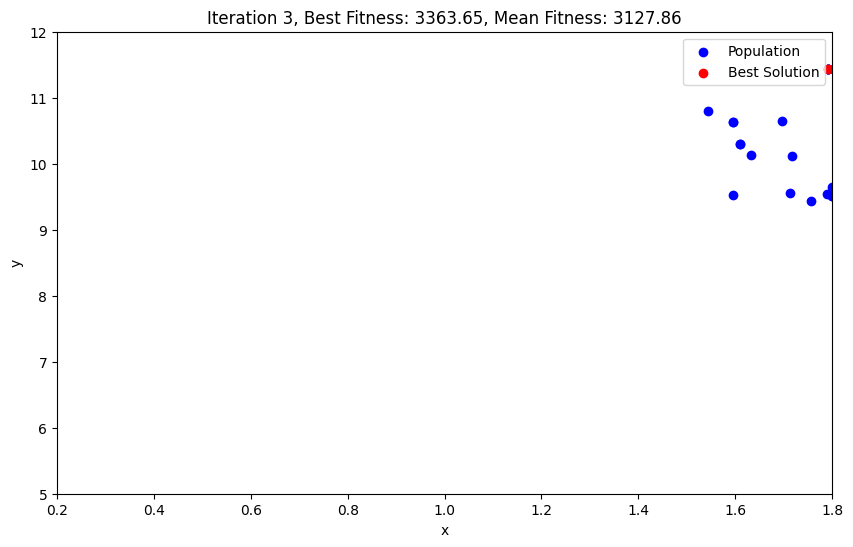

Assemble
GridFunction
CG iteration 1, residual = 689922.929874761     
CG iteration 2, residual = 4.446818368968907e-10     
Máximo valor de la temperatura: 289.1635005032595
Assemble
GridFunction
CG iteration 1, residual = 666423.7718112947     
CG iteration 2, residual = 4.3262428139511185e-10     
Máximo valor de la temperatura: 289.51611893415134
Assemble
GridFunction
CG iteration 1, residual = 722102.0652624518     
CG iteration 2, residual = 5.07246570132091e-10     
Máximo valor de la temperatura: 288.5668152404631
Assemble
GridFunction
CG iteration 1, residual = 642499.7105197703     
CG iteration 2, residual = 3.8721410579821976e-10     
Máximo valor de la temperatura: 290.0972769623746
Assemble
GridFunction
CG iteration 1, residual = 665335.6085619724     
CG iteration 2, residual = 4.144464296995254e-10     
Máximo valor de la temperatura: 289.59664357281304
Assemble
GridFunction
CG iteration 1, residual = 674474.6234176995     
CG iteration 2, residual = 4.1328822599247475e

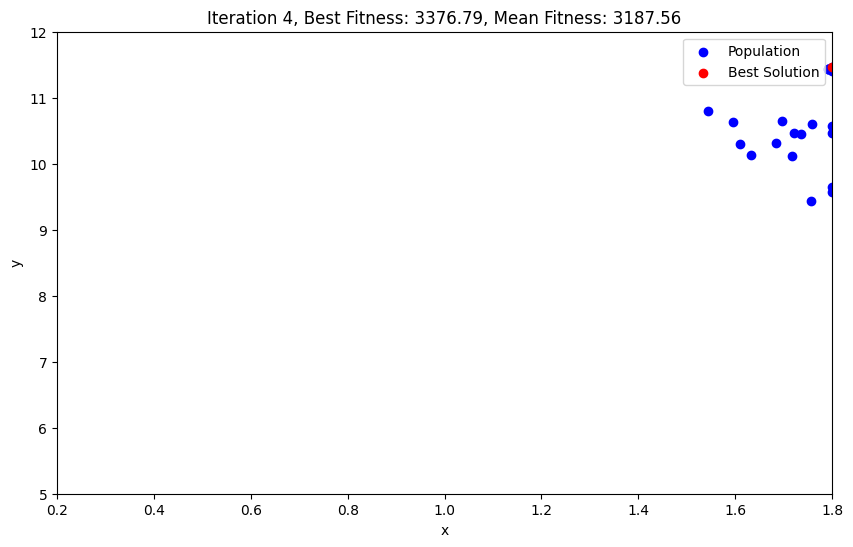

Assemble
GridFunction
CG iteration 1, residual = 704660.5577349688     
CG iteration 2, residual = 3.9771565168759947e-10     
Máximo valor de la temperatura: 288.81607662403917
Assemble
GridFunction
CG iteration 1, residual = 689922.929874761     
CG iteration 2, residual = 4.446818368968907e-10     
Máximo valor de la temperatura: 289.1635005032595
Assemble
GridFunction
CG iteration 1, residual = 673582.2572376587     
CG iteration 2, residual = 4.3730570697328377e-10     
Máximo valor de la temperatura: 289.45533652288754
Assemble
GridFunction
CG iteration 1, residual = 664920.8066977588     
CG iteration 2, residual = 4.2739840575618264e-10     
Máximo valor de la temperatura: 289.6051009035815
Assemble
GridFunction
CG iteration 1, residual = 663284.9118232853     
CG iteration 2, residual = 4.0179304353532833e-10     
Máximo valor de la temperatura: 289.645381338356
Assemble
GridFunction
CG iteration 1, residual = 689922.929874761     
CG iteration 2, residual = 4.446818368968907e

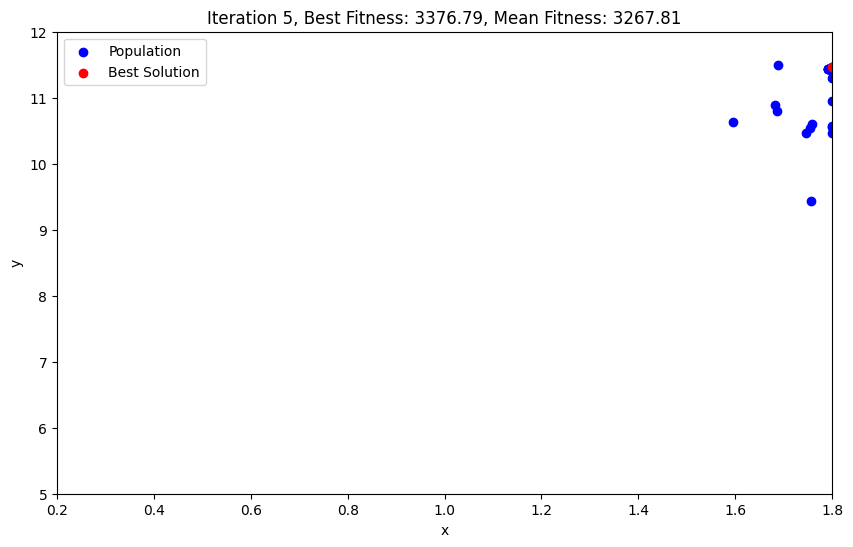

Assemble
GridFunction
CG iteration 1, residual = 686951.6203524157     
CG iteration 2, residual = 4.1525217711376814e-10     
Máximo valor de la temperatura: 289.2178302200322
Assemble
GridFunction
CG iteration 1, residual = 689130.6792966378     
CG iteration 2, residual = 4.356162261564388e-10     
Máximo valor de la temperatura: 289.1814541067202
Assemble
GridFunction
CG iteration 1, residual = 682428.402396765     
CG iteration 2, residual = 4.1642949400083805e-10     
Máximo valor de la temperatura: 289.2523199973406
Assemble
GridFunction
CG iteration 1, residual = 687372.0469988742     
CG iteration 2, residual = 4.3371895233114257e-10     
Máximo valor de la temperatura: 289.1743275142445
Assemble
GridFunction
CG iteration 1, residual = 675252.4214922392     
CG iteration 2, residual = 4.362041977691403e-10     
Máximo valor de la temperatura: 289.40326921979687
Assemble
GridFunction
CG iteration 1, residual = 684516.4869642565     
CG iteration 2, residual = 4.494341543178078e

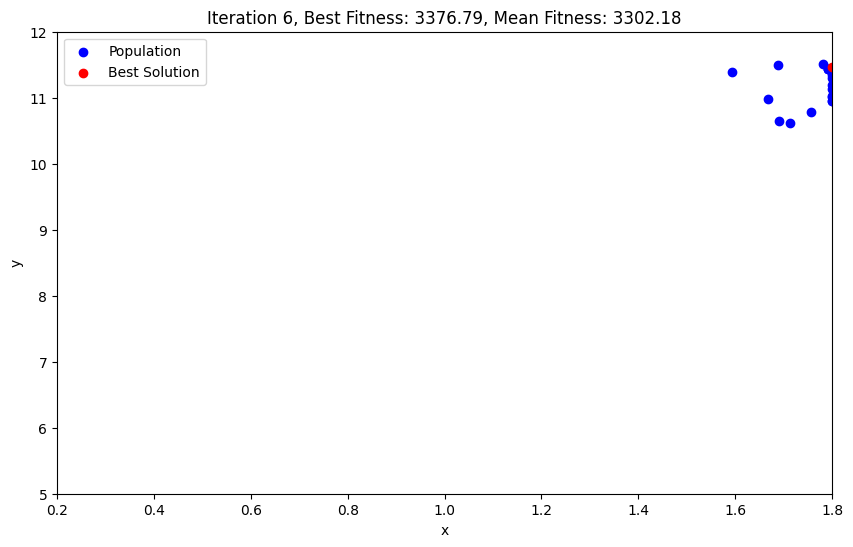

Assemble
GridFunction
CG iteration 1, residual = 690329.0398563176     
CG iteration 2, residual = 4.3149883820995304e-10     
Máximo valor de la temperatura: 289.1496075837512
Assemble
GridFunction
CG iteration 1, residual = 690235.4898239184     
CG iteration 2, residual = 4.81281215582823e-10     
Máximo valor de la temperatura: 289.1363400361244
Assemble
GridFunction
CG iteration 1, residual = 686951.6203524157     
CG iteration 2, residual = 4.1525217711376814e-10     
Máximo valor de la temperatura: 289.2178302200322
Assemble
GridFunction
CG iteration 1, residual = 687420.0628051567     
CG iteration 2, residual = 3.9956288186713986e-10     
Máximo valor de la temperatura: 289.1925531236055
Assemble
GridFunction
CG iteration 1, residual = 682957.5689670247     
CG iteration 2, residual = 4.5814079364526216e-10     
Máximo valor de la temperatura: 289.26869092797205
Assemble
GridFunction
CG iteration 1, residual = 682789.0593506688     
CG iteration 2, residual = 4.306960139036478

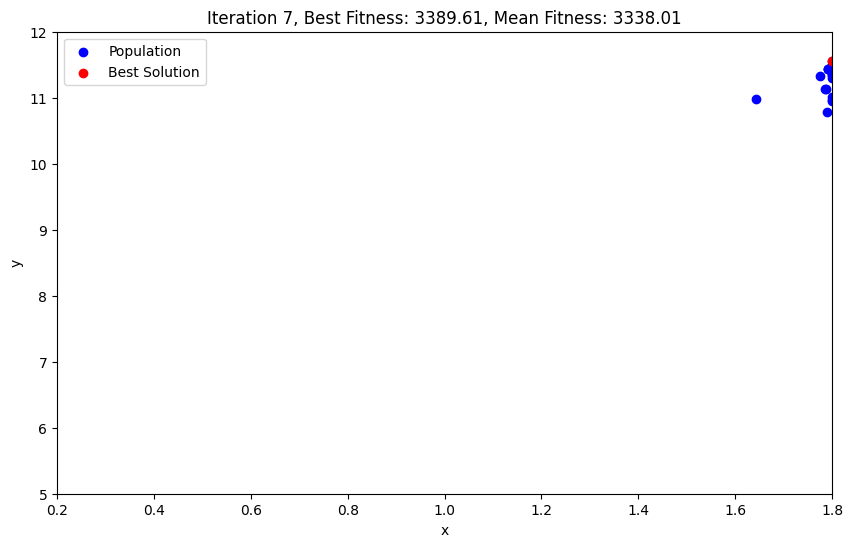

Assemble
GridFunction
CG iteration 1, residual = 689399.6208649202     
CG iteration 2, residual = 4.219666106153811e-10     
Máximo valor de la temperatura: 289.1764777301905
Assemble
GridFunction
CG iteration 1, residual = 686802.0818088433     
CG iteration 2, residual = 4.911191447787542e-10     
Máximo valor de la temperatura: 289.2185528613114
Assemble
GridFunction
CG iteration 1, residual = 702683.4935819911     
CG iteration 2, residual = 4.3608394485122687e-10     
Máximo valor de la temperatura: 288.8888059212262
Assemble
GridFunction
CG iteration 1, residual = 699917.8002439649     
CG iteration 2, residual = 4.307986717575609e-10     
Máximo valor de la temperatura: 288.9738565469589
Assemble
GridFunction
CG iteration 1, residual = 689922.929874761     
CG iteration 2, residual = 4.446818368968907e-10     
Máximo valor de la temperatura: 289.1635005032595
Assemble
GridFunction
CG iteration 1, residual = 689922.929874761     
CG iteration 2, residual = 4.446818368968907e-10 

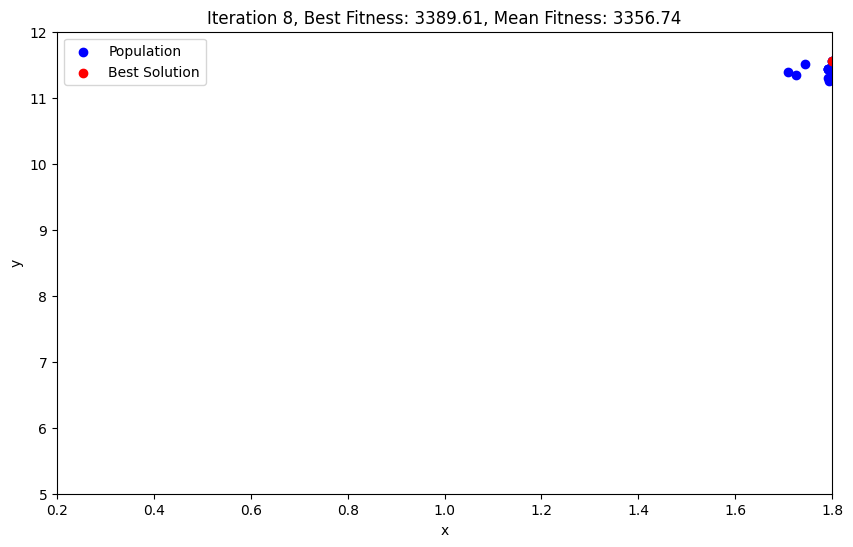

Assemble
GridFunction
CG iteration 1, residual = 689130.6792966378     
CG iteration 2, residual = 4.356162261564388e-10     
Máximo valor de la temperatura: 289.1814541067202
Assemble
GridFunction
CG iteration 1, residual = 689399.6208649202     
CG iteration 2, residual = 4.219666106153811e-10     
Máximo valor de la temperatura: 289.1764777301905
Assemble
GridFunction
CG iteration 1, residual = 689922.929874761     
CG iteration 2, residual = 4.446818368968907e-10     
Máximo valor de la temperatura: 289.1635005032595
Assemble
GridFunction
CG iteration 1, residual = 689922.929874761     
CG iteration 2, residual = 4.446818368968907e-10     
Máximo valor de la temperatura: 289.1635005032595
Assemble
GridFunction
CG iteration 1, residual = 687420.0628051567     
CG iteration 2, residual = 3.9956288186713986e-10     
Máximo valor de la temperatura: 289.1925531236055
Assemble
GridFunction
CG iteration 1, residual = 688143.1707461318     
CG iteration 2, residual = 4.4475625844204245e-10

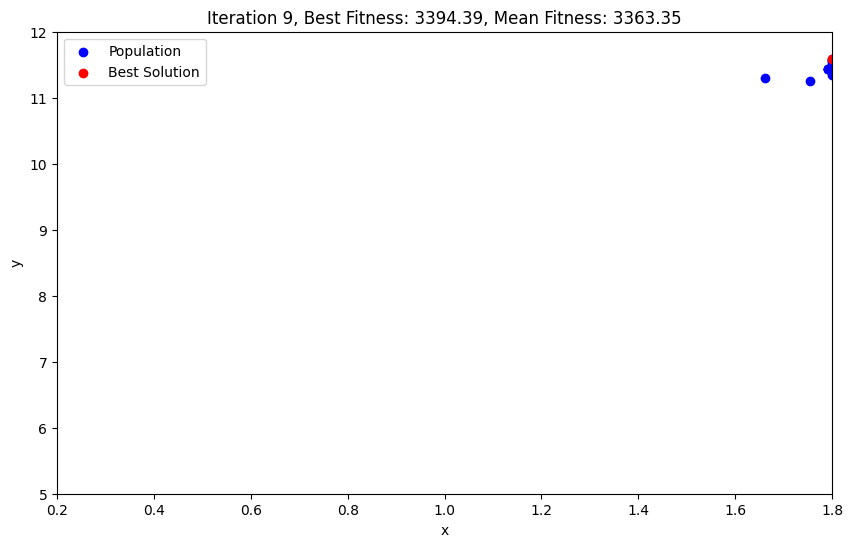

Assemble
GridFunction
CG iteration 1, residual = 689372.451147413     
CG iteration 2, residual = 4.679206298408581e-10     
Máximo valor de la temperatura: 289.17698007249476
Assemble
GridFunction
CG iteration 1, residual = 690235.4898239184     
CG iteration 2, residual = 4.81281215582823e-10     
Máximo valor de la temperatura: 289.1363400361244
Assemble
GridFunction
CG iteration 1, residual = 691518.8927919364     
CG iteration 2, residual = 4.5279657264646904e-10     
Máximo valor de la temperatura: 289.120667482189
Assemble
GridFunction
CG iteration 1, residual = 691113.3039124964     
CG iteration 2, residual = 4.863724410382506e-10     
Máximo valor de la temperatura: 289.13352692542134
Assemble
GridFunction
CG iteration 1, residual = 701756.0973557337     
CG iteration 2, residual = 4.5079245965710484e-10     
Máximo valor de la temperatura: 288.94048260824565
Assemble
GridFunction
CG iteration 1, residual = 697601.946670779     
CG iteration 2, residual = 4.29212864996565e-10

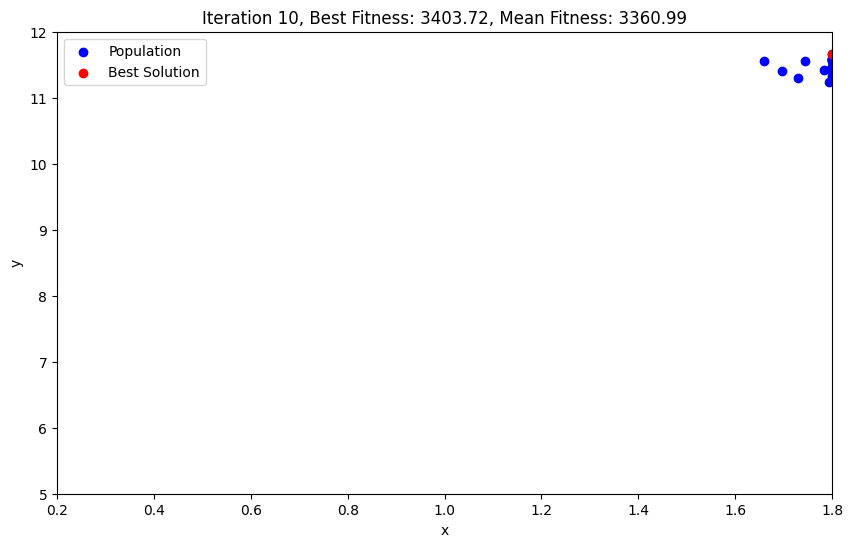

In [9]:
# Inicialización de variables para almacenar la mejor solución y su fitness
best_solution = None
best_fitness = float('-inf')
mean_fitnesses = []

# Función de selección de padres (torneo binario)
def select_parents(population, fitness):
    idxs = np.random.choice(len(population), size=2, replace=False)
    return population[idxs[np.argmax(fitness[idxs])]]
    
# Función de cruce (crossover)
def crossover(parent1, parent2):
    if np.random.rand() < crossover_rate:
        child1 = 0.5 * (parent1 + parent2) + np.random.normal(0, 0.1, size=2)
        child2 = 0.5 * (parent1 + parent2) + np.random.normal(0, 0.1, size=2)
        # Verificar límites de los hijos y ajustar si es necesario
        child1 = np.clip(child1, [espesor_range[0], radio_externo_range[0]], [espesor_range[1], radio_externo_range[1]])
        child2 = np.clip(child2, [espesor_range[0], radio_externo_range[0]], [espesor_range[1], radio_externo_range[1]])
        return child1, child2
    return parent1, parent2

# Función de mutación
def mutate(individual):
    if np.random.rand() < mutation_rate:
        individual += np.random.normal(0, 0.1, size=2)
        # Verificar límites y ajustar si es necesario
        individual = np.clip(individual, [espesor_range[0], radio_externo_range[0]], [espesor_range[1], radio_externo_range[1]])
    return individual

# Algoritmo genético
for j in range(num_iterations):
    # Selección de padres y cruce
    new_population = []
    for _ in range(population_size // 2):
        parent1 = select_parents(population, fitness)
        parent2 = select_parents(population, fitness)
        child1, child2 = crossover(parent1, parent2)
        new_population.extend([mutate(child1), mutate(child2)])

    # Elitismo
    if elitism:
        num_elite = int(population_size * 0.10)
        elite_idxs = np.argsort(fitness)[-num_elite:]
        new_population[:num_elite] = population[elite_idxs]

    # Actualización de la población
    population = np.array(new_population)

    # Evaluación de la población
    fitness = np.array([objective_function(x, longitud_segmentos_rectos, graficar=False) for x in population])
    mean_fitness = np.mean(fitness)
    mean_fitnesses.append(mean_fitness)

    # Actualización de la mejor solución
    if np.max(fitness) >= best_fitness:
        best_fitness = np.max(fitness)
        best_solution = population[np.argmax(fitness)]
    print(f"Iteration {j+1}, Best Solution: {best_solution}, Best Fitness: {best_fitness}")

    # Mostrar gráficas de la iteración actual
    plt.figure(figsize=(10, 6))
    plt.scatter(population[:, 0], population[:, 1], c='b', label='Population')
    plt.scatter(best_solution[0], best_solution[1], c='r', label='Best Solution')
    plt.axhline(y=0, color='gray', linestyle='--')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f"Iteration {j+1}, Best Fitness: {best_fitness:.2f}, Mean Fitness: {mean_fitness:.2f}")
    plt.legend()
    plt.xlim(espesor_range)
    plt.ylim(radio_externo_range)
    plt.show()

In [10]:
# Calcular y mostrar la mejor solución con su geometría y resultados
area, temp_max = areamax_tempmax(espesor=best_solution[0], radio_externo=best_solution[1], longitud_segmentos_rectos=longitud_segmentos_rectos, graficar=True)
print(f"Mejor Solución (espesor, radio_externo): {best_solution}")
print(f"Área: {area}, Temperatura Máxima: {temp_max}")

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  138.636

Assemble
GridFunction
CG iteration 1, residual = 695725.4037426071     
CG iteration 2, residual = 4.2571602638169533e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Máximo valor de la temperatura: 289.0787420613047
Mejor Solución (espesor, radio_externo): [ 1.8        11.66431663]
Área:  138.636
, Temperatura Máxima: 289.0787420613047


- `best_solution = None`, `best_fitness = float('-inf')`, `mean_fitnesses = []`: Inicializan variables para almacenar la mejor solución encontrada, su fitness y la lista de fitness promedio por iteración.

- `select_parents(population, fitness)`: Función que selecciona los padres para el cruce utilizando un torneo binario.

- `crossover(parent1, parent2)`: Función que realiza el cruce entre dos padres, generando dos hijos con una probabilidad dada por `crossover_rate`.

- `mutate(individual)`: Función que realiza la mutación de un individuo con una probabilidad dada por `mutation_rate`.

- Bucle principal del algoritmo genético:
  - Selecciona padres, realiza el cruce y la mutación para generar una nueva población.
  - Aplica elitismo si está activado.
  - Evalúa la nueva población y actualiza la mejor solución si se encuentra un individuo con un fitness mejor.
  - Imprime información sobre la iteración actual.
  - Muestra una gráfica con la población actual y la mejor solución encontrada hasta el momento.


Assemble
GridFunction
CG iteration 1, residual = 690986.5527147006     
CG iteration 2, residual = 4.425779409476017e-10     
Máximo valor de la temperatura: 289.1456390824465
Assemble
GridFunction
CG iteration 1, residual = 695747.8464008182     
CG iteration 2, residual = 4.2096660032106147e-10     
Máximo valor de la temperatura: 289.0783381318876
Assemble
GridFunction
CG iteration 1, residual = 687366.4639492519     
CG iteration 2, residual = 4.4342096345879384e-10     
Máximo valor de la temperatura: 289.19352859194953
Assemble
GridFunction
CG iteration 1, residual = 714810.821345225     
CG iteration 2, residual = 4.835277233676335e-10     
Máximo valor de la temperatura: 288.73006056255707
Assemble
GridFunction
CG iteration 1, residual = 687882.3616350172     
CG iteration 2, residual = 4.375869457129543e-10     
Máximo valor de la temperatura: 289.2005703132372
Assemble
GridFunction
CG iteration 1, residual = 726260.453105436     
CG iteration 2, residual = 4.472875358593593e-

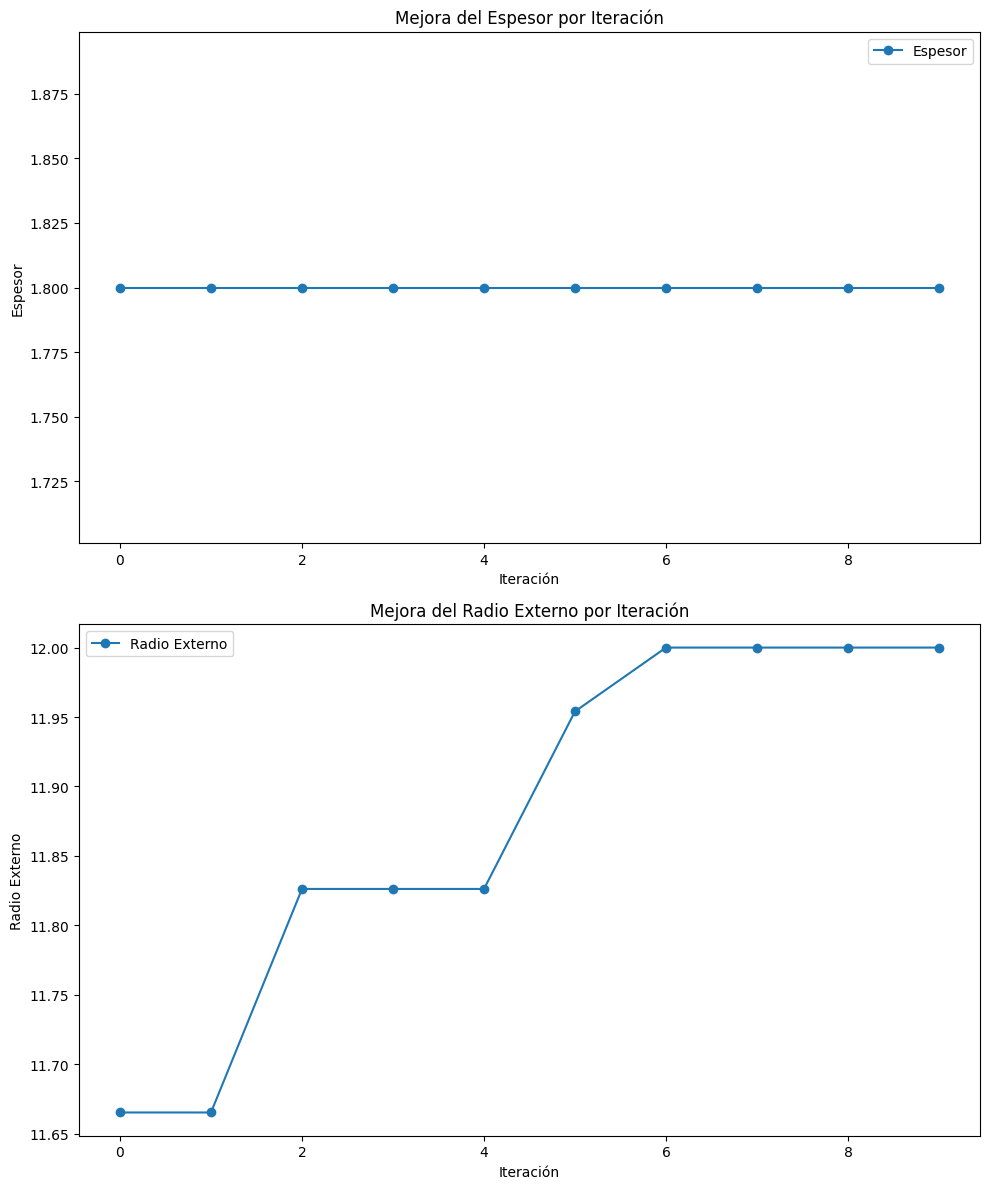

In [11]:
# Inicialización de variables para almacenar la mejor solución y su fitness
best_solutions = []
mean_fitnesses = []

# Algoritmo genético
for j in range(num_iterations):
    # Selección de padres y cruce
    new_population = []
    for _ in range(population_size // 2):
        parent1 = select_parents(population, fitness)
        parent2 = select_parents(population, fitness)
        child1, child2 = crossover(parent1, parent2)
        new_population.extend([mutate(child1), mutate(child2)])

    # Elitismo
    if elitism:
        num_elite = int(population_size * 0.10)
        elite_idxs = np.argsort(fitness)[-num_elite:]
        new_population[:num_elite] = population[elite_idxs]

    # Actualización de la población
    population = np.array(new_population)

    # Evaluación de la población
    fitness = np.array([objective_function(x, longitud_segmentos_rectos, graficar=False) for x in population])
    mean_fitness = np.mean(fitness)
    mean_fitnesses.append(mean_fitness)

    # Actualización de la mejor solución
    if np.max(fitness) >= best_fitness:
        best_fitness = np.max(fitness)
        best_solution = population[np.argmax(fitness)]

    # Guardar las mejores soluciones
    best_solutions.append(best_solution)

    # Visualización de la mejora de las soluciones
    print(f"Iteración {j+1}, Mejor Solución: {best_solution}, Mejor Aptitud: {best_fitness}")

# Convertir las mejores soluciones en un array numpy
best_solutions = np.array(best_solutions)

# Graficar la mejora de las soluciones
fig, ax = plt.subplots(2, 1, figsize=(10, 12))

# Gráfico para el espesor
ax[0].plot(range(num_iterations), best_solutions[:, 0], 'o-', label='Espesor')
ax[0].set_xlabel('Iteración')
ax[0].set_ylabel('Espesor')
ax[0].set_title('Mejora del Espesor por Iteración')
ax[0].legend()

# Gráfico para el radio externo
ax[1].plot(range(num_iterations), best_solutions[:, 1], 'o-', label='Radio Externo')
ax[1].set_xlabel('Iteración')
ax[1].set_ylabel('Radio Externo')
ax[1].set_title('Mejora del Radio Externo por Iteración')
ax[1].legend()

plt.tight_layout()
plt.show()
